In [1]:
pip install --upgrade category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid",
			{"grid.color": ".6",
			"grid.linestyle": ":"})
import category_encoders as ce
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [4]:
# reading dataset using panda
tinder_df = pd.read_csv("tinder_data.csv")


In [5]:
# shape of the dataset
print(tinder_df.shape)


(2001, 20)


In [6]:
# information about the dataset
tinder_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              2001 non-null   object
 1   username             2001 non-null   object
 2   age                  2001 non-null   int64 
 3   status               2001 non-null   object
 4   sex                  2001 non-null   object
 5   orientation          2001 non-null   object
 6   drinks               2001 non-null   object
 7   drugs                2001 non-null   object
 8   height               2001 non-null   int64 
 9   job                  2001 non-null   object
 10  location             2001 non-null   object
 11  pets                 2001 non-null   object
 12  smokes               2001 non-null   object
 13  language             2001 non-null   object
 14  new_languages        2001 non-null   object
 15  body_profile         2001 non-null   object
 16  educat

In [ ]:
# Number of unique element in the columns
tinder_df.nunique()


In [7]:
tinder_df.groupby(['sex', 'drugs'])['drugs'] \
	.count() \
	.reset_index(name='unique_drug_count')


,sex,drugs,unique_drug_count
0,f,never,711
1,f,often,5
2,f,sometimes,146
3,m,never,875
4,m,often,13
5,m,sometimes,251


In [ ]:
tinder_df.groupby(['new_languages', 'dropped_out']) \
			['dropped_out'].count(). \
			reset_index(name='drop_out_people count')


<AxesSubplot:xlabel='age', ylabel='Count'>

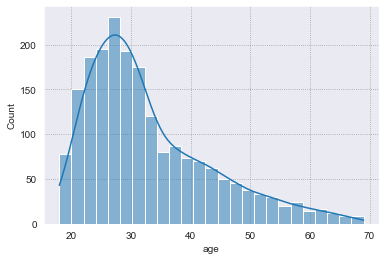

In [8]:
# distribution of age
sns.histplot(tinder_df["age"], kde=True)


In [ ]:
# Distribution of height
sns.histplot(tinder_df["height"], kde=True)


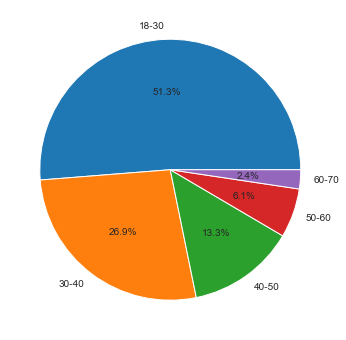

In [9]:
# Set the size of the figure to 10 inches
# wide by 8 inches tall
plt.figure(figsize=(6, 6))

# Divide the data into categories
bins = [18, 30, 40, 50, 60, 70]

# Use the `cut` function to assign
# each data point to a category
categories = pd.cut(tinder_df["age"], bins,
					labels=["18-30", "30-40",
							"40-50", "50-60", "60-70"])

# Count the number of data points in each category
counts = categories.value_counts()

# Plot the data as a pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.show()


In [ ]:
plt.figure(figsize=(6, 6))
sns.histplot(x="job", data=tinder_df,
			color="coral")

# rotate x-axis labels vertically
plt.xticks(rotation=90)
plt.title("Distribution of job of each candidate",
		fontsize=14)

plt.xlabel("Job id", fontsize=12)
plt.ylabel("Count of people", fontsize=12)

plt.show()


In [10]:
# check if every row has a
# common language as english
tinder_df['language'].str.contains('english')\
	.unique()


array([ True])

In [11]:
# count the number of languages in each row
tinder_df['num_languages'] = tinder_df['language']\
	.str.count(',') + 1
tinder_df.drop(["language"], axis=1, inplace=True)


In [12]:
place_type_strength = {
	'anywhere': 1.0,
	'same state': 2.0,
	'same city': 2.5
}

tinder_df['location_preference'] = \
	tinder_df['location_preference']\
	.apply(lambda x: place_type_strength[x])


In [13]:
two_unique_values_column = {
	'sex': {'f': 1, 'm': 0},
	'dropped_out': {'no': 0, 'yes': 1}
}

tinder_df.replace(two_unique_values_column,
				inplace=True)


In [14]:
status_type_strength = {
	'single': 2.0,
	'available': 2.0,
	'seeing someone': 1.0,
	'married': 1.0
}
tinder_df['status'] = tinder_df['status']\
	.apply(lambda x:
		status_type_strength[x])


In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# create a LabelEncoder object
orientation_encoder = LabelEncoder()

# fit the encoder on the orientation column
orientation_encoder.fit(tinder_df['orientation'])

# encode the orientation column using the fitted encoder
tinder_df['orientation'] = orientation_encoder.\
	transform(tinder_df['orientation'])

# Drop the existing orientation column
tinder_df.drop("orientation", axis=1, inplace=True)


In [17]:
drinking_habit = {
	'socially': 'sometimes',
	'rarely': 'sometimes',
	'not at all': 'do not drink',
	'often': 'drinks often',
	'very often': 'drinks often',
	'desperately': 'drinks often'
}
tinder_df['drinks'] = tinder_df['drinks']\
	.apply(lambda x:
		drinking_habit[x])
# create a LabelEncoder object
habit_encoder = LabelEncoder()

# fit the encoder on the drinks and drugs columns
habit_encoder.fit(tinder_df[['drinks', 'drugs']]
				.values.reshape(-1))

# encode the drinks and drugs columns
# using the fitted encoder
tinder_df['drinks_encoded'] = \
	habit_encoder.transform(tinder_df['drinks'])
tinder_df['drugs_encoded'] = \
	habit_encoder.transform(tinder_df['drugs'])

# Drop the existing drink and drugs column
tinder_df.drop(["drinks", "drugs"], axis=1,
			inplace=True)


In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
region_dict = {'southern_california': ['los angeles',
						'san diego', 'hacienda heights',
						'north hollywood', 'phoenix'],
			'new_york': ['brooklyn',
							'new york']}

def get_region(city):
	for region, cities in region_dict.items():
		if city.lower() in [c.lower() for c in cities]:
			return region
	return "northern_california"


tinder_df['location'] = tinder_df['location']\
		.str.split(', ')\
		.str[0].apply(get_region)
# perform one hot encoding
location_encoder = OneHotEncoder()

# fit and transform the location column
location_encoded = location_encoder.fit_transform\
					(tinder_df[['location']])

# create a new DataFrame with the encoded columns
location_encoded_df = pd.DataFrame(location_encoded.toarray()\
						, columns=location_encoder.\
						get_feature_names_out(['location']))

# concatenate the new DataFrame with the original DataFrame
tinder_df = pd.concat([tinder_df, location_encoded_df], axis=1)
# Drop the existing location column
tinder_df.drop(["location"], axis=1, inplace=True)


In [20]:
# create a LabelEncoder object
job_encoder = LabelEncoder()

# fit the encoder on the job column
job_encoder.fit(tinder_df['job'])

# encode the job column using the fitted encoder
tinder_df['job_encoded'] = job_encoder.\
	transform(tinder_df['job'])

# drop the original job column
tinder_df.drop('job', axis=1, inplace=True)


In [21]:
smokes = {
'no': 1.0,
'sometimes': 0,
'yes': 0,
'when drinking':0,
'trying to quit':0
}
tinder_df['smokes'] = tinder_df['smokes']\
							.apply(lambda x: smokes[x])


In [22]:
bin_enc = ce.BinaryEncoder(cols=['pets'])

# fit and transform the pet column
pet_enc = bin_enc.fit_transform(tinder_df['pets'])

# add the encoded columns to the original dataframe
tinder_df = pd.concat([tinder_df, pet_enc], axis=1)

tinder_df.drop("pets",axis=1,inplace = True)


In [23]:
# create a LabelEncoder object
location_encoder = LabelEncoder()

# fit the encoder on the job column
location_encoder.fit(tinder_df['new_languages'])

# encode the job column using the fitted encoder
tinder_df['new_languages'] = location_encoder.transform(
	tinder_df['new_languages'])

# create an instance of LabelEncoder
le = LabelEncoder()

# encode the body_profile column
tinder_df["body_profile"] = le.fit_transform(tinder_df["body_profile"])


In [24]:
# Initialize TfidfVectorizer object
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(tinder_df['bio'])

# Get the feature names from the TfidfVectorizer object
feature_names = tfidf.vocabulary_

# Convert tfidf matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
						columns=feature_names)

# Add non-text features to the tfidf_df dataframe
tinder_dfs = tinder_df.drop(["bio", "user_id",
							"username"], axis=1)
tinder_dfs = pd.concat([tinder_dfs,
						tfidf_df], axis=1)
# Apply SVD to the feature matrix
svd = TruncatedSVD(n_components=100)
svd_matrix = svd.fit_transform(tinder_dfs)

# Calculate the cosine similarity
# between all pairs of users
cosine_sim = cosine_similarity(svd_matrix)


In [25]:
def recommend(user_df, num_recommendations=5):

	# Apply SVD to the feature
	# matrix of the user_df dataframe
	svd_matrixs = svd.transform(user_df)

	# Calculate the cosine similarity
	# between the user_df and training set users
	cosine_sim_new = cosine_similarity(svd_matrixs, svd_matrix)

	# Get the indices of the top
	# num_recommendations similar users
	sim_scores = list(enumerate(cosine_sim_new[0]))
	sim_scores = sorted(sim_scores,
						key=lambda x: x[1], reverse=True)
	sim_indices = [i[0] for i in
				sim_scores[1:num_recommendations+1]]

	# Return the user_ids of the recommended users
	return tinder_df['username'].iloc[sim_indices]


In [ ]:
user_df = {}

# Get user input for numerical columns
user_df['age'] = float(input("Enter age: "))
user_df['status'] = float(input("Enter status: "))
user_df['sex'] = float(input("Enter sex \
			(0 for female, 1 for male): "))
user_df['height'] = float(input("Enter \
				height in inches: "))
user_df['smokes'] = float(input("Enter smokes\
				(0 for no, 1 for yes): "))
user_df['new_languages'] = float(
	input("Enter number of new \
		languages learned: "))
user_df['body_profile'] = float(input("Enter body \
			profile (0-1)"))
user_df['education_level'] = float(input("Enter \
			education level (1-5): "))
user_df['dropped_out'] = float(
	input("Enter dropped out (0 for no, 1 for yes): "))
user_df['bio'] = [input("Enter bio: ")]
user_df['location_preference'] = float(
	input("Enter location preference (0-2): "))
user_df['num_languages'] = float(input("\
			Enter number of languages known: "))
user_df['drinks_encoded'] = float(input("\
			Enter drinks encoded (0-3): "))
user_df['drugs_encoded'] = float(input("\
				Enter drugs encoded (0-2): "))

# Get user input for one-hot encoded categorical columns
user_df['location_new_york'] = float(
	input("Enter location_new_york (0 or 1): "))
user_df['location_northern_california'] = float(
	input("Enter location_northern_california (0 or 1): "))
user_df['location_southern_california'] = float(
	input("Enter location_southern_california (0 or 1): "))
user_df['job_encoded'] = float(input("\
			Enter job encoded (0-9): "))
user_df['pets_0'] = float(input("\
				Enter pets_0 (0 or 1): "))
user_df['pets_1'] = float(input("\
				Enter pets_1 (0 or 1): "))
user_df['pets_2'] = float(input("\
			Enter pets_2 (0 or 1): "))
user_df['pets_3'] = float(input("\
				Enter pets_3 (0 or 1): "))

# Convert tfidf matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf.transform(
	user_df['bio']).toarray(), columns=feature_names)

# Convert the user input
# dictionary to a Pandas DataFrame
user_df = pd.DataFrame(user_df, index=[0])
user_df.drop("bio", axis=1, inplace=True)
user_df = pd.concat([user_df, tfidf_df], axis=1)


Enter age: 23
Enter status: 2
Enter sex 			(0 for female, 1 for male): 0
